# Predictive Models 101: From Predictions to Policies

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Chapter 17 | Notebook 3 of 3**

This notebook bridges the gap between ML predictions and actionable business decisions
through thresholding policies and quantile banding.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

---

## 1. Intuition {#intuition}

### Predictions vs Policies

**Prediction**: A number estimating something - $\hat{E}[Y|X]$
- Example: "This customer will generate 16 BRL in revenue"

**Policy**: An automatic decision rule using predictions
- Example: "Engage with customers whose predicted value > 10"

> **Key Insight**: Predictions alone are useless. We need policies to act on them.

### Policy Design Spectrum

| Policy Type | Decision | Complexity | Example |
|-------------|----------|------------|----------|
| Treat-all | Same for everyone | None | Email everyone |
| Threshold | Binary cutoff | Low | Engage if pred > 0 |
| Quantile bands | Discrete levels | Medium | Marketing tiers |
| Continuous | Function of prediction | High | Bid = pred × 0.3 |

---

## 2. Formal Treatment {#formal}

### 2.1 Thresholding Policy

Given predictions $\hat{y}_i = \hat{E}[Y_i|X_i]$, a threshold policy is:

$$\pi(X_i) = \mathbf{1}\{\hat{y}_i > \tau\}$$

where $\tau$ is the decision threshold (often 0 for profitability).

**Expected value under policy**:
$$V(\pi) = E[Y \cdot \pi(X)] = E[Y | \hat{y} > \tau] \cdot P(\hat{y} > \tau)$$

### 2.2 Quantile Banding

Partition predictions into $K$ bands using quantiles:

$$B_k = \{i : q_{k-1} < \hat{y}_i \leq q_k\}$$

where $q_k$ is the $k/K$-th quantile of $\hat{y}$.

**Action allocation**: Different actions per band
$$a_i = f(B(i))$$

Example: Marketing spend proportional to band:
$$\text{spend}_i = \alpha \cdot B(i)$$

### 2.3 Policy Evaluation

**Value per customer** (normalized by total customers):
$$\bar{V} = \frac{1}{N} \sum_{i \in \pi} Y_i$$

**Lift over baseline**:
$$\text{Lift} = \frac{\bar{V}_{\text{policy}}}{\bar{V}_{\text{treat-all}}}$$

**ROI consideration**:
$$\text{ROI} = \frac{\sum_{i \in \pi} Y_i - \text{Cost}(\pi)}{\text{Cost}(\pi)}$$

---

## 3. Numeric Demonstration {#numeric}

### Load and Prepare Data

In [2]:
# Load data
transactions = load_facure_data("customer_transactions.csv")
profitable = transactions[['customer_id']].assign(
    net_value=transactions.drop(columns='customer_id').sum(axis=1)
)
customer_features = load_facure_data("customer_features.csv").merge(
    profitable, on='customer_id'
)

# Train-test split
train, test = train_test_split(customer_features, test_size=0.3, random_state=13)

# Feature engineering: encode region
region_means = train.groupby('region')['net_value'].mean().to_dict()

def encode_region(df, region_means):
    return df.assign(region_encoded=df['region'].map(region_means).fillna(0))

train_enc = encode_region(train, region_means)
test_enc = encode_region(test, region_means)

features = ['region_encoded', 'income', 'age']
target = 'net_value'

In [3]:
# Train model
model = GradientBoostingRegressor(
    n_estimators=400,
    max_depth=4,
    min_samples_split=10,
    learning_rate=0.01,
    random_state=123
)
model.fit(train_enc[features], train_enc[target])

# Generate predictions
test_with_pred = test_enc.assign(prediction=model.predict(test_enc[features]))

print(f"Test R²: {r2_score(test_enc[target], test_with_pred['prediction']):.4f}")
print(f"Prediction range: [{test_with_pred['prediction'].min():.1f}, {test_with_pred['prediction'].max():.1f}]")

Test R²: 0.6939
Prediction range: [-530.5, 82.4]


### Comparing Policy Types

In [4]:
# Policy 1: Treat all
treat_all_value = test['net_value'].sum() / len(test)

# Policy 2: Region-based (from previous notebook)
region_stats = train.groupby('region')['net_value'].agg(['mean', 'count', 'std'])
region_stats['lower_bound'] = (
    region_stats['mean'] - 1.96 * region_stats['std'] / np.sqrt(region_stats['count'])
)
profitable_regions = region_stats[region_stats['lower_bound'] > 0].index.tolist()
region_policy = test[test['region'].isin(profitable_regions)]
region_value = region_policy['net_value'].sum() / len(test)

# Policy 3: Threshold at 0
threshold_policy = test_with_pred[test_with_pred['prediction'] > 0]
threshold_value = threshold_policy['net_value'].sum() / len(test)

# Summary
policies = pd.DataFrame({
    'Policy': ['Treat All', 'Region Only', 'ML Threshold > 0'],
    'Customers Engaged': [len(test), len(region_policy), len(threshold_policy)],
    'Value per Customer': [treat_all_value, region_value, threshold_value]
})
policies['Engagement Rate'] = policies['Customers Engaged'] / len(test) * 100
policies['Lift'] = policies['Value per Customer'] / treat_all_value

print(policies.to_string(index=False))

          Policy  Customers Engaged  Value per Customer  Engagement Rate    Lift
       Treat All               3000            -26.1753         100.0000  1.0000
     Region Only               1124             15.5707          37.4667 -0.5949
ML Threshold > 0               1305             16.5977          43.5000 -0.6341


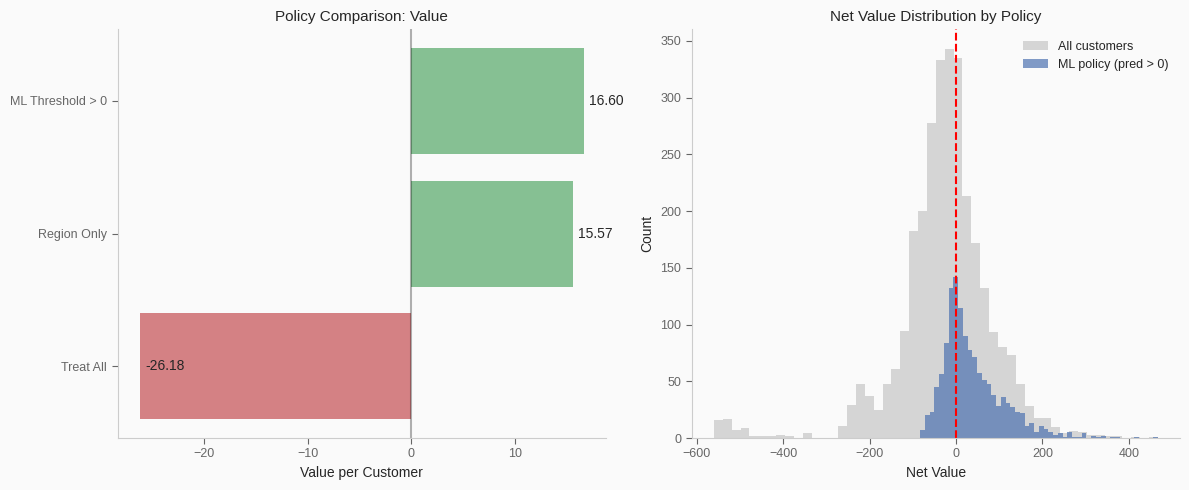

In [5]:
# Visualize policy comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Value comparison
ax = axes[0]
colors = [COLORS['red'] if v < 0 else COLORS['green'] for v in policies['Value per Customer']]
ax.barh(policies['Policy'], policies['Value per Customer'], color=colors, alpha=0.7)
ax.axvline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Value per Customer')
ax.set_title('Policy Comparison: Value')
for i, v in enumerate(policies['Value per Customer']):
    ax.text(v + 0.5, i, f'{v:.2f}', va='center')
apply_tufte_style(ax)

# Distribution of outcomes by policy
ax = axes[1]
ax.hist(test['net_value'], bins=50, alpha=0.3, label='All customers', color='gray')
ax.hist(threshold_policy['net_value'], bins=50, alpha=0.7, 
        label='ML policy (pred > 0)', color=COLORS['blue'])
ax.axvline(0, color='red', linestyle='--')
ax.set_xlabel('Net Value')
ax.set_ylabel('Count')
ax.set_title('Net Value Distribution by Policy')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

### Threshold Sensitivity Analysis

In [6]:
# Test different thresholds
thresholds = np.linspace(-100, 100, 41)
threshold_results = []

for tau in thresholds:
    selected = test_with_pred[test_with_pred['prediction'] > tau]
    if len(selected) > 0:
        threshold_results.append({
            'threshold': tau,
            'n_engaged': len(selected),
            'engagement_rate': len(selected) / len(test),
            'total_value': selected['net_value'].sum(),
            'value_per_customer': selected['net_value'].sum() / len(test),
            'avg_value_engaged': selected['net_value'].mean()
        })

threshold_df = pd.DataFrame(threshold_results)

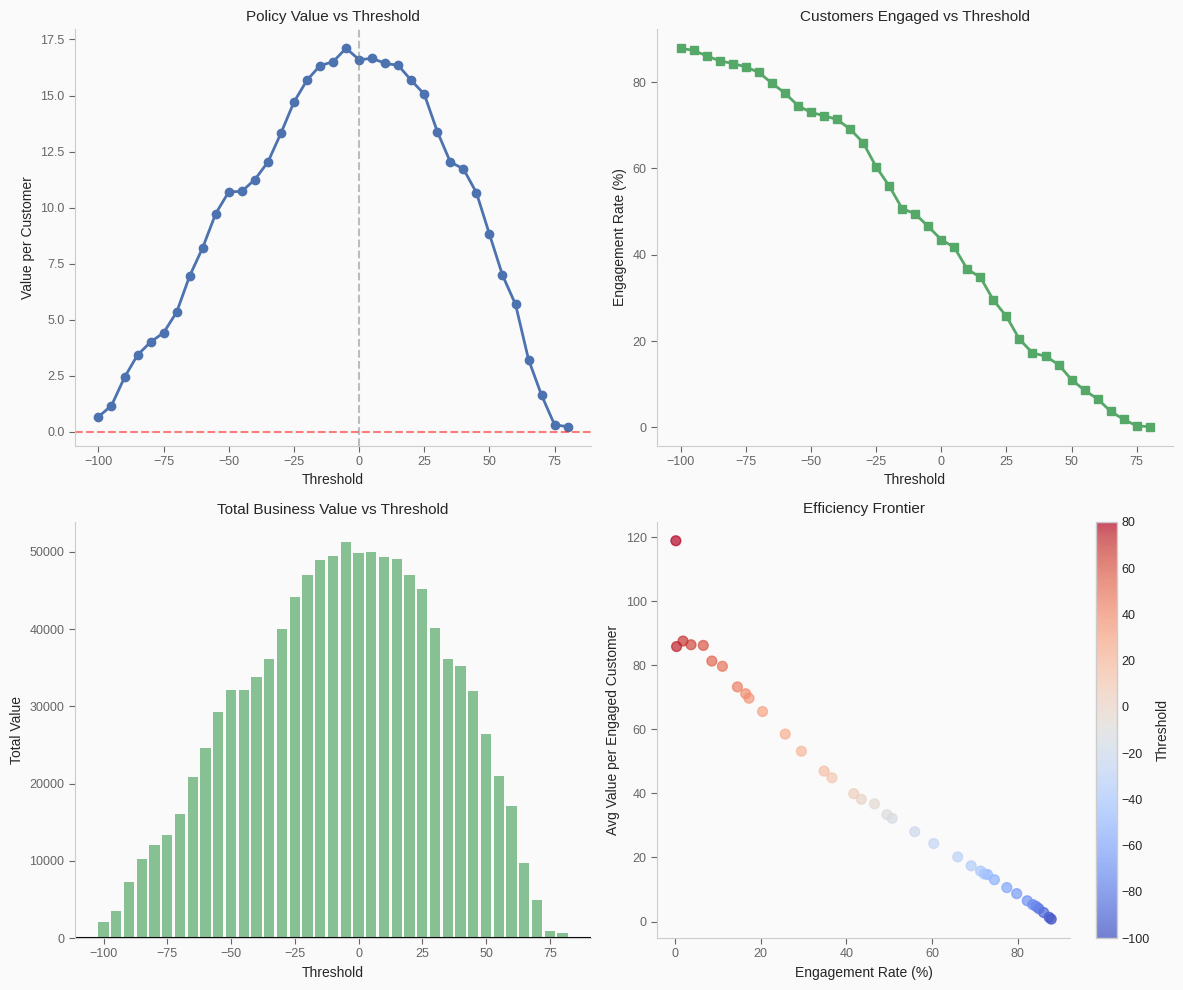


Optimal threshold: -5
Value per customer: 17.11
Engagement rate: 46.6%


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Value per customer vs threshold
ax = axes[0, 0]
ax.plot(threshold_df['threshold'], threshold_df['value_per_customer'], 
        'o-', color=COLORS['blue'], linewidth=2)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Threshold')
ax.set_ylabel('Value per Customer')
ax.set_title('Policy Value vs Threshold')
apply_tufte_style(ax)

# Engagement rate vs threshold
ax = axes[0, 1]
ax.plot(threshold_df['threshold'], threshold_df['engagement_rate'] * 100, 
        's-', color=COLORS['green'], linewidth=2)
ax.set_xlabel('Threshold')
ax.set_ylabel('Engagement Rate (%)')
ax.set_title('Customers Engaged vs Threshold')
apply_tufte_style(ax)

# Total value vs threshold (business perspective)
ax = axes[1, 0]
colors = [COLORS['green'] if v > 0 else COLORS['red'] for v in threshold_df['total_value']]
ax.bar(threshold_df['threshold'], threshold_df['total_value'], color=colors, alpha=0.7, width=4)
ax.axhline(0, color='black', linestyle='-')
ax.set_xlabel('Threshold')
ax.set_ylabel('Total Value')
ax.set_title('Total Business Value vs Threshold')
apply_tufte_style(ax)

# Efficiency frontier: avg value vs engagement
ax = axes[1, 1]
scatter = ax.scatter(threshold_df['engagement_rate'] * 100, 
                     threshold_df['avg_value_engaged'],
                     c=threshold_df['threshold'], cmap='coolwarm',
                     s=50, alpha=0.7)
plt.colorbar(scatter, ax=ax, label='Threshold')
ax.set_xlabel('Engagement Rate (%)')
ax.set_ylabel('Avg Value per Engaged Customer')
ax.set_title('Efficiency Frontier')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

# Optimal threshold
optimal_idx = threshold_df['value_per_customer'].idxmax()
print(f"\nOptimal threshold: {threshold_df.loc[optimal_idx, 'threshold']:.0f}")
print(f"Value per customer: {threshold_df.loc[optimal_idx, 'value_per_customer']:.2f}")
print(f"Engagement rate: {threshold_df.loc[optimal_idx, 'engagement_rate']:.1%}")

---

## 4. Implementation {#implementation}

### Quantile Banding for Fine-Grain Decisions

In [8]:
def create_model_bands(train_predictions, n_bands=20):
    """Create quantile bands from training predictions.
    
    IMPORTANT: Bands must be computed on training set and applied to test set
    to avoid data leakage.
    """
    _, bins = pd.qcut(train_predictions, q=n_bands, retbins=True, duplicates='drop')
    
    def assign_band(predictions):
        return np.digitize(predictions, bins)
    
    return assign_band, bins

In [9]:
# Create bands from training predictions
train_pred = model.predict(train_enc[features])
assign_band, band_bins = create_model_bands(train_pred, n_bands=20)

# Apply to test set
test_banded = test_with_pred.assign(band=assign_band(test_with_pred['prediction']))

# Analyze bands
band_stats = test_banded.groupby('band').agg(
    count=('net_value', 'count'),
    mean_value=('net_value', 'mean'),
    std_value=('net_value', 'std'),
    mean_pred=('prediction', 'mean')
).reset_index()

print("Band Statistics (sorted by prediction):")
print(band_stats.to_string(index=False))

Band Statistics (sorted by prediction):
 band  count  mean_value  std_value  mean_pred
    1    144   -336.0278   155.0371  -326.8800
    2    150   -159.3333    69.7250  -162.8476
    3    169   -103.4970    54.4320   -97.3650
    4    135    -66.9704    57.3753   -71.5030
    5    149    -53.8926    58.6632   -60.5321
    6    160    -45.2750    64.7528   -46.1831
    7    134    -33.5448    66.4237   -32.5169
    8    154    -28.5779    64.2509   -26.3853
    9    140    -20.8357    62.5188   -22.1055
   10    126     -9.8730    63.3589   -17.6658
   11    170    -11.2118    54.8991    -8.9525
   12    127      3.0709    62.4814     0.6145
   13    155      4.0258    57.3354     8.4507
   14    154     11.8247    57.4886    15.4527
   15    166     16.2590    52.9317    21.7731
   16    152     31.5658    50.6919    26.9733
   17    129     42.7597    68.8592    33.4674
   18    166     54.0000    80.0152    46.4674
   19    167     76.0898    72.4441    56.7289
   20    153     85.

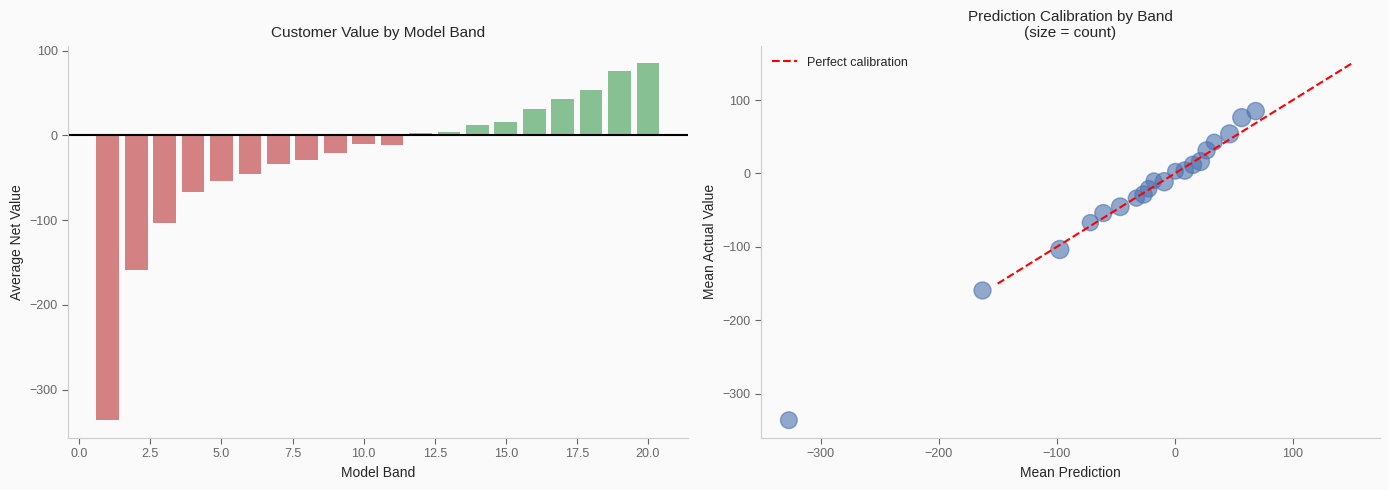

In [10]:
# Visualize band performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean value by band
ax = axes[0]
colors = [COLORS['green'] if v > 0 else COLORS['red'] for v in band_stats['mean_value']]
ax.bar(band_stats['band'], band_stats['mean_value'], color=colors, alpha=0.7)
ax.axhline(0, color='black', linestyle='-')
ax.set_xlabel('Model Band')
ax.set_ylabel('Average Net Value')
ax.set_title('Customer Value by Model Band')
apply_tufte_style(ax)

# Prediction vs actual by band
ax = axes[1]
ax.scatter(band_stats['mean_pred'], band_stats['mean_value'], 
           s=band_stats['count'], alpha=0.6, color=COLORS['blue'])
ax.plot([-150, 150], [-150, 150], 'r--', label='Perfect calibration')
ax.set_xlabel('Mean Prediction')
ax.set_ylabel('Mean Actual Value')
ax.set_title('Prediction Calibration by Band\n(size = count)')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

### Marketing Investment Policy

In [11]:
# Define marketing spend by band
# Higher bands get more investment
def marketing_policy(band, max_spend=50):
    """Marketing spend proportional to band."""
    if band <= 5:  # Bottom quartile: no investment
        return 0
    elif band <= 10:  # Low: minimal
        return 5
    elif band <= 15:  # Medium: moderate
        return 20
    else:  # High: maximum
        return max_spend

test_banded = test_banded.assign(
    marketing_spend=test_banded['band'].apply(marketing_policy)
)

# Calculate ROI by band
spend_by_band = test_banded.groupby('band').agg(
    total_value=('net_value', 'sum'),
    total_spend=('marketing_spend', 'sum'),
    count=('net_value', 'count')
).reset_index()
spend_by_band['net_profit'] = spend_by_band['total_value'] - spend_by_band['total_spend']
# ROI only defined where spend > 0; use 0 for no-spend bands
spend_by_band['roi'] = np.where(
    spend_by_band['total_spend'] > 0,
    (spend_by_band['total_value'] - spend_by_band['total_spend']) / spend_by_band['total_spend'],
    0.0  # No spend = no ROI calculation
)

print("Marketing Spend Analysis by Band (with spending):")
# Show only bands with spending for ROI analysis
with_spend = spend_by_band[spend_by_band['total_spend'] > 0]
print(with_spend[['band', 'count', 'total_value', 'total_spend', 'net_profit', 'roi']].to_string(index=False))

Marketing Spend Analysis by Band (with spending):
 band  count  total_value  total_spend  net_profit      roi
    6    160        -7244          800       -8044 -10.0550
    7    134        -4495          670       -5165  -7.7090
    8    154        -4401          770       -5171  -6.7156
    9    140        -2917          700       -3617  -5.1671
   10    126        -1244          630       -1874  -2.9746
   11    170        -1906         3400       -5306  -1.5606
   12    127          390         2540       -2150  -0.8465
   13    155          624         3100       -2476  -0.7987
   14    154         1821         3080       -1259  -0.4088
   15    166         2699         3320        -621  -0.1870
   16    152         4798         7600       -2802  -0.3687
   17    129         5516         6450        -934  -0.1448
   18    166         8964         8300         664   0.0800
   19    167        12707         8350        4357   0.5218
   20    153        13012         7650        5362

In [12]:
# Overall policy summary
total_value = spend_by_band['total_value'].sum()
total_spend = spend_by_band['total_spend'].sum()
net_profit = total_value - total_spend

print(f"\nOverall Policy Results:")
print(f"  Total customer value: {total_value:,.0f}")
print(f"  Total marketing spend: {total_spend:,.0f}")
print(f"  Net profit: {net_profit:,.0f}")
print(f"  Overall ROI: {(total_value - total_spend) / total_spend:.1%}")


Overall Policy Results:
  Total customer value: -78,526
  Total marketing spend: 57,360
  Net profit: -135,886
  Overall ROI: -236.9%


```
★ Insight ─────────────────────────────────────────────────────
Quantile banding enables nuanced decisions:

1. **Binary threshold**: Good for engage/don't engage
2. **Quantile bands**: Good for resource allocation
3. **Continuous**: Good for bidding/pricing

The right choice depends on the business decision structure.
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: What's the difference between a prediction and a policy?

<details>
<summary>Solution</summary>

**Prediction**: A number estimating $E[Y|X]$
- Output of a model
- Example: "This customer's expected value is 16"

**Policy**: A decision rule built on predictions
- Converts predictions into actions
- Example: "Engage if prediction > 0"

**Key insight**: Predictions alone are useless without policies to act on them.

**Real-world examples**:
- Fraud detection: Prediction = fraud score, Policy = block if score > threshold
- Credit: Prediction = default probability, Policy = approval/rate based on score
- Marketing: Prediction = LTV, Policy = spending tier based on value

</details>

### Q2: How do you choose the right threshold for a policy?

<details>
<summary>Solution</summary>

**Approach**:

1. **Define objective**: What are you maximizing?
   - Total profit
   - Profit per customer
   - ROI
   - F1 score (if classification)

2. **Consider costs**:
   - Cost of false positives (engaging with unprofitable)
   - Cost of false negatives (missing profitable)
   - Fixed vs variable costs

3. **Sweep thresholds**:
   - Plot objective vs threshold
   - Find optimum
   - Consider stability (not on cliff edge)

4. **Validate**:
   - Cross-validation or holdout set
   - Check for overfitting to training threshold

**Common approaches**:
- Break-even: threshold = 0 for profitability
- Maximize F1: balance precision/recall
- Business constraint: "Must engage at least 30% of customers"

</details>

### Q3: When should you use quantile banding vs continuous predictions?

<details>
<summary>Solution</summary>

**Use quantile banding when**:
- Decisions are naturally discrete (tiers, categories)
- Need interpretability for stakeholders
- Model predictions are noisy at individual level
- Operational constraints require grouping

**Use continuous predictions when**:
- Decisions are continuous (bidding, pricing)
- Model is well-calibrated
- Fine-grained optimization matters
- Systems can handle personalized values

**Hybrid approach**:
- Continuous prediction internally
- Binned for reporting and monitoring
- Enables tracking by segment while optimizing

</details>

---

## 6. References {#references}

[^1]: Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning*.

[^2]: Mullainathan, S., & Spiess, J. (2017). Machine Learning: An Applied Econometric Approach.
      *Journal of Economic Perspectives*, 31(2), 87-106.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 17.